<a href="https://colab.research.google.com/github/victorkingbuilder/FlockingHeat/blob/main/Flocking_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import deque
from matplotlib.patches import Polygon
from sklearn.mixture import GaussianMixture
from scipy.interpolate import make_interp_spline
from statsmodels.nonparametric.smoothers_lowess import lowess # Import lowess for smoothing
import time # Added for performance timing
from sklearn.metrics import silhouette_score, adjusted_rand_score # Added for clustering evaluation and ARI
from sklearn.metrics import mean_squared_error # Added for MSE calculation
from scipy.stats import entropy, gaussian_kde, shapiro # Added for KL divergence, KDE, and Shapiro-Wilk
from scipy.stats import probplot # Added for Q-Q plot

# New imports for comparing clustering methods
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler # For Z-score normalization in clustering preprocessing
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os

folder_path = '/content/drive/My Drive/Swarm_Behavior_Data/'

if os.path.exists(folder_path):
   print("Folder found. Files in the folder:")
   print(os.listdir(folder_path))
else:
   print("Folder not found. Please check the path.")

Folder found. Files in the folder:
['Aligned.csv', 'Flocking.csv', 'Grouped.csv']


In [5]:
import pandas as pd

try:
    df_aligned = pd.read_csv(os.path.join(folder_path, 'Aligned.csv'))
    df_flocking = pd.read_csv(os.path.join(folder_path, 'Flocking.csv'))
    df_group = pd.read_csv(os.path.join(folder_path, 'Grouped.csv'))

    print("\nDatasets loaded successfully:")
    print("Aligned dataset head:")
    print(df_aligned.head())
    print("\nFlocking dataset head:")
    print(df_flocking.head())
    print("\nGroup dataset head:")
    print(df_group.head())

except FileNotFoundError:
    print("Error: One or more of the CSV files were not found. Check the file names and path.")
except Exception as e:
    print(f"An error occurred while loading the data: {e}")

<ipython-input-5-681b4e704af2>:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_flocking = pd.read_csv(os.path.join(folder_path, 'Flocking.csv'))



Datasets loaded successfully:
Aligned dataset head:
        x1      y1  xVel1  yVel1   xA1  yA1     xS1     yS1   xC1   yC1  ...  \
0 -1414.14 -535.22 -17.88  -7.23  0.00  0.0    0.00    0.00  0.00  0.00  ...   
1 -1412.93  597.54 -13.55  -5.48  0.00  0.0    0.00    0.00  0.00  0.00  ...   
2 -1407.38   70.72 -14.37  -5.81  0.00  0.0    0.00    0.00  0.00  0.00  ...   
3 -1407.00 -759.80  -7.59  -1.27 -0.98 -0.2    0.00    0.00  0.91  0.41  ...   
4 -1406.36  698.39 -16.54  -6.95 -1.00  0.0 -944.07 -396.62  0.00  0.00  ...   

   yVel200  xA200  yA200  xS200  yS200  xC200  yC200  nAC200  nS200  Class  
0   -16.85    0.0   0.00    0.0    0.0   0.00   0.00      29      0      0  
1   -12.09    0.0   0.00    0.0    0.0   0.00   0.00      44      0      0  
2   -16.20    0.0   0.00    0.0    0.0   0.00   0.00      40      0      0  
3     2.99   -1.0  -0.07    0.0    0.0  -0.52   0.86       3      0      1  
4   -12.61    0.0  -1.00    0.0    0.0   0.00   0.00      13      0      0  

[5 

In [6]:
# Explore the columns of each dataframe
print("Columns in df_aligned:")
print(df_aligned.columns)

print("\nColumns in df_flocking:")
print(df_flocking.columns)

print("\nColumns in df_group:")
print(df_group.columns)

Columns in df_aligned:
Index(['x1', 'y1', 'xVel1', 'yVel1', 'xA1', 'yA1', 'xS1', 'yS1', 'xC1', 'yC1',
       ...
       'yVel200', 'xA200', 'yA200', 'xS200', 'yS200', 'xC200', 'yC200',
       'nAC200', 'nS200', 'Class'],
      dtype='object', length=2401)

Columns in df_flocking:
Index(['x1', 'y1', 'xVel1', 'yVel1', 'xA1', 'yA1', 'xS1', 'yS1', 'xC1', 'yC1',
       ...
       'yVel200', 'xA200', 'yA200', 'xS200', 'yS200', 'xC200', 'yC200',
       'nAC200', 'nS200', 'Class '],
      dtype='object', length=2401)

Columns in df_group:
Index(['x1', 'y1', 'xVel1', 'yVel1', 'xA1', 'yA1', 'xS1', 'yS1', 'xC1', 'yC1',
       ...
       'yVel200', 'xA200', 'yA200', 'xS200', 'yS200', 'xC200', 'yC200',
       'nAC200', 'nS200', 'Class'],
      dtype='object', length=2401)


In [7]:
print(df_flocking['x1'].dtypes)
print(df_flocking['x1'].unique())
df_flocking['x1'] = pd.to_numeric(df_flocking['x1'], errors='coerce')
df_flocking.dropna(subset=['x1'], inplace=True)

object
[-1414.14 -1412.93 -1407.38 ... '1404.61' '1406.08' ' ']


In [8]:
print("\nDescriptive statistics for df_flocking:")
print(df_flocking.describe())


Descriptive statistics for df_flocking:
                 x1            y1         xVel1         yVel1           xA1  \
count  24015.000000  24015.000000  24015.000000  24015.000000  24015.000000   
mean     108.280413    -73.075164     -0.737349      0.041626     -0.148095   
std      842.179950    572.563956      6.445383      7.374829      0.377036   
min    -1414.140000  -1012.180000    -18.590000    -18.410000     -1.000000   
25%     -539.665000   -609.365000     -5.520000     -5.710000     -0.230000   
50%      156.010000   -156.710000     -0.460000     -1.600000      0.000000   
75%      898.135000    424.460000      3.820000      7.310000      0.000000   
max     1406.080000   1015.800000     18.470000     18.630000      1.000000   

                yA1           xS1           yS1           xC1           yC1  \
count  24015.000000  24015.000000  24015.000000  24015.000000  24015.000000   
mean       0.150991     -1.217259     -0.835834     -0.035582      0.075811   
std       

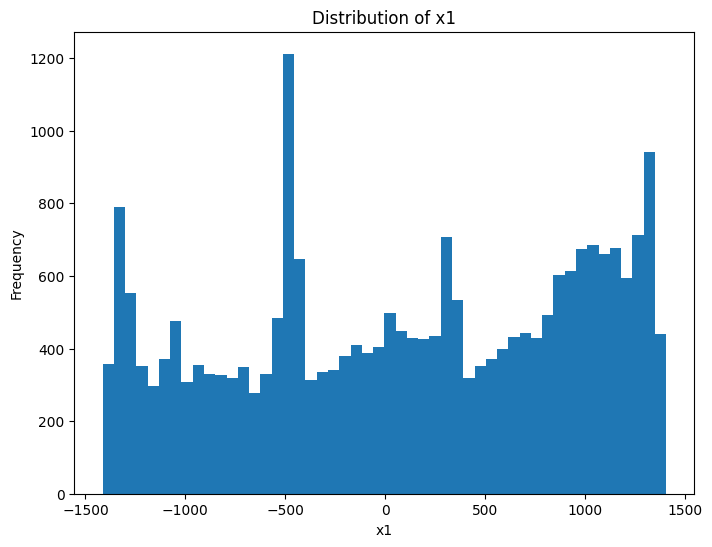

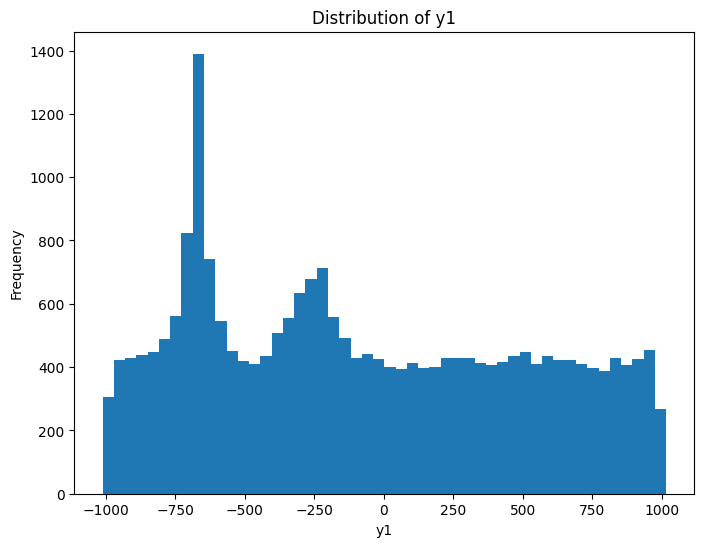

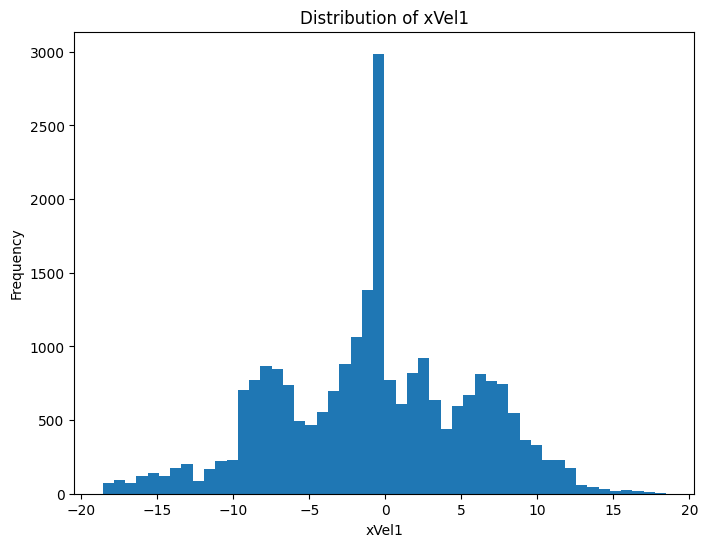

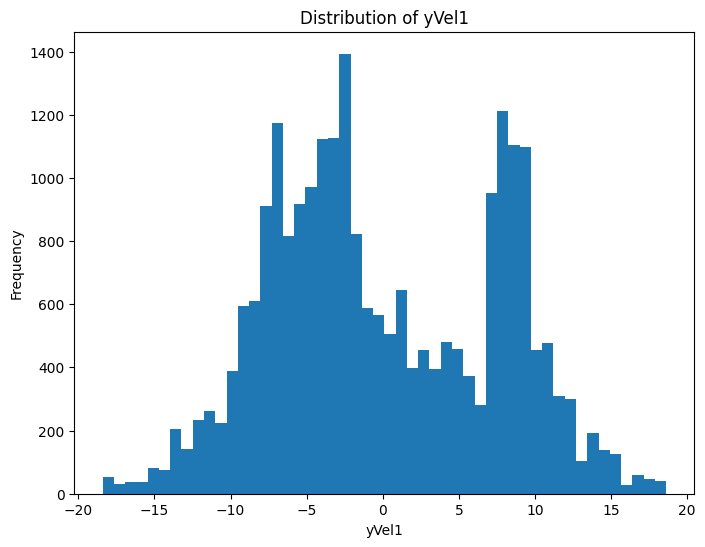

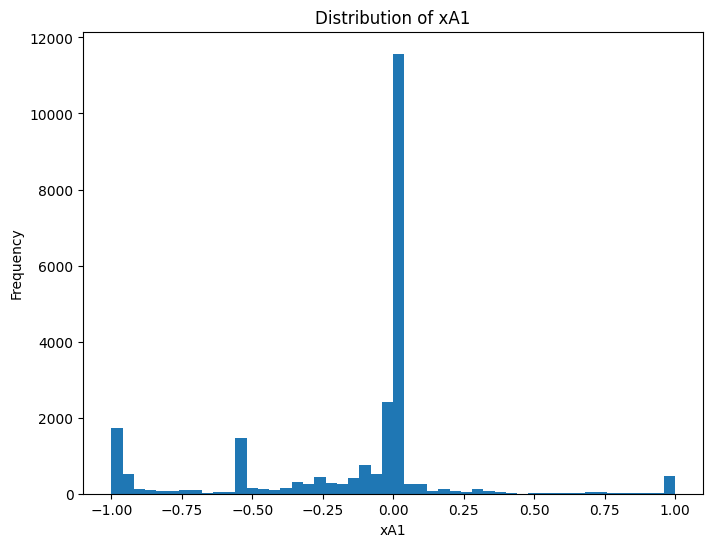

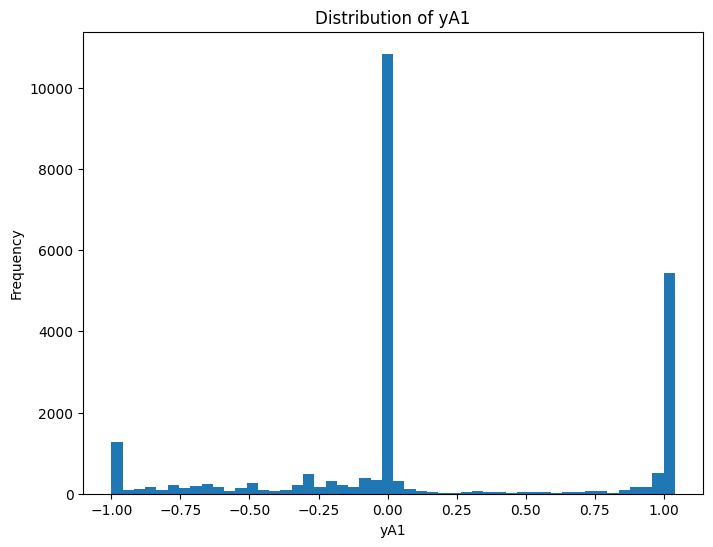

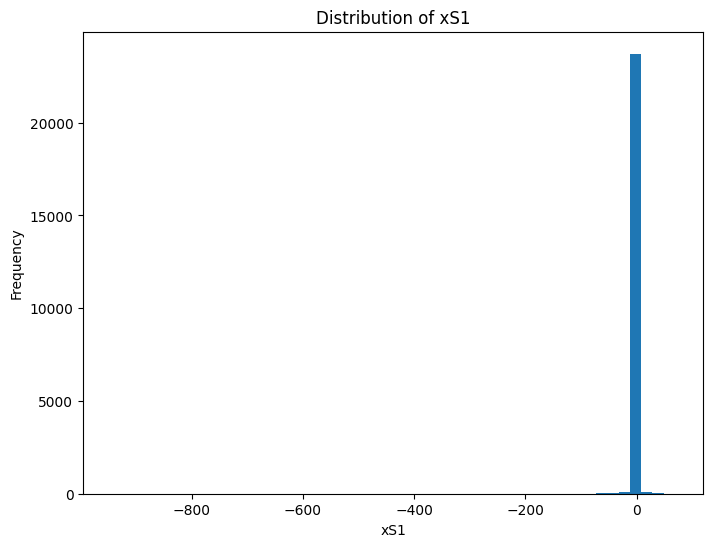

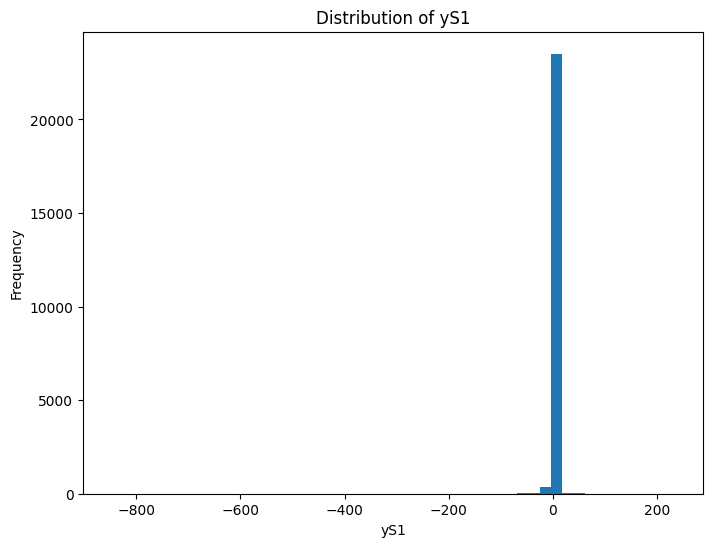

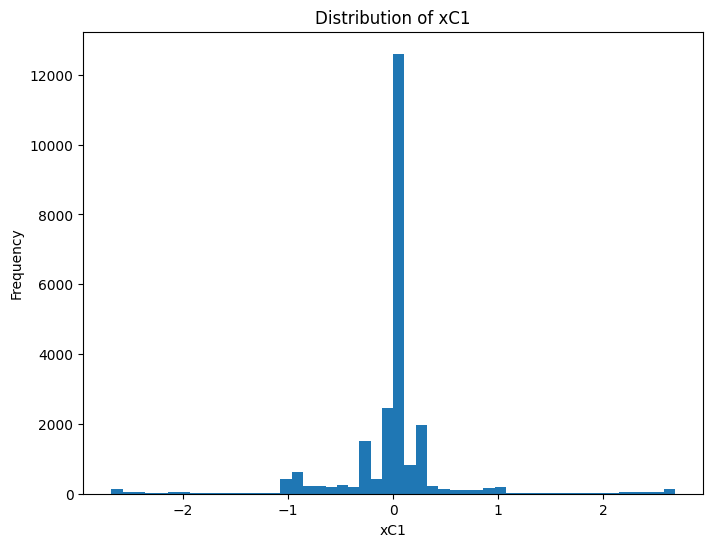

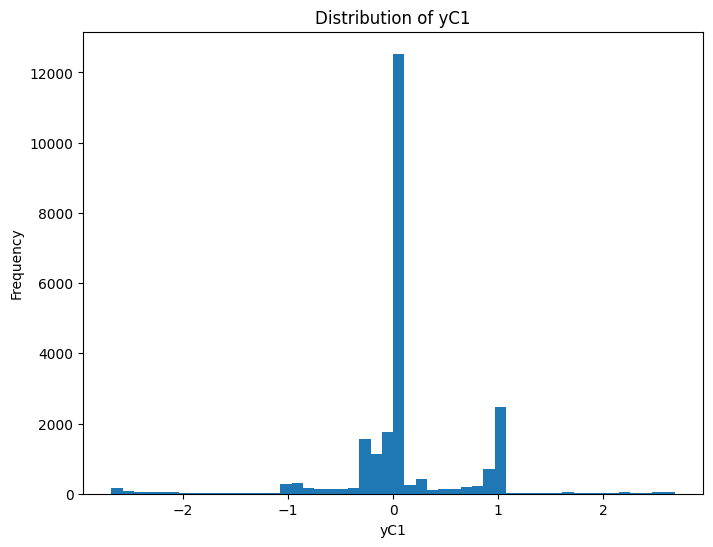

In [9]:
import matplotlib.pyplot as plt

# Choose a few columns you think are relevant to positions, velocities, or distances
# Replace 'column_name_1', 'column_name_2', etc. with actual column names from df_flocking
columns_to_visualize = ['x1','y1','xVel1', 'yVel1','xA1', 'yA1', 'xS1', 'yS1', 'xC1', 'yC1'] # Add more column names here

for col in columns_to_visualize:
    if col in df_flocking.columns:
        plt.figure(figsize=(8, 6))
        plt.hist(df_flocking[col], bins=50)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()
    else:
        print(f"Column '{col}' not found in df_flocking.")

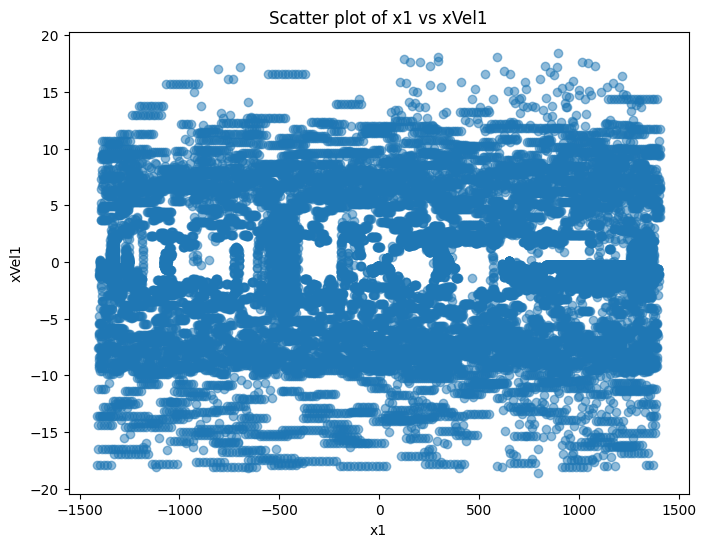

In [10]:
# Choose two columns to plot against each other
# Replace 'feature_1' and 'feature_2' with actual column names from df_flocking
feature_1 = 'x1'
feature_2 = 'xVel1'

if feature_1 in df_flocking.columns and feature_2 in df_flocking.columns:
    plt.figure(figsize=(8, 6))
    plt.scatter(df_flocking[feature_1], df_flocking[feature_2], alpha=0.5)
    plt.title(f'Scatter plot of {feature_1} vs {feature_2}')
    plt.xlabel(feature_1)
    plt.ylabel(feature_2)
    plt.show()
else:
    print(f"One or both columns '{feature_1}' and '{feature_2}' not found in df_flocking.")

## 1. Average Velocity of the Swarm:
To calculate the average velocity of the swarm at each time step, we took the average of the x and y velocity components across all agents.

In [11]:
# Assuming velocity columns are named xVel1, yVel1, xVel2, yVel2, etc.
# You'll need to adapt this if your column names are different or you have a different number of agents

# Select all columns that represent x and y velocities
x_vel_cols = [col for col in df_flocking.columns if 'xVel' in col]
y_vel_cols = [col for col in df_flocking.columns if 'yVel' in col]

# Calculate the average x and y velocity across all agents
df_flocking['avg_x_velocity'] = df_flocking[x_vel_cols].mean(axis=1)
df_flocking['avg_y_velocity'] = df_flocking[y_vel_cols].mean(axis=1)

# Calculate the magnitude of the average velocity
df_flocking['avg_velocity_magnitude'] = np.sqrt(df_flocking['avg_x_velocity']**2 + df_flocking['avg_y_velocity']**2)

print("\nAverage velocity columns added to df_flocking:")
print(df_flocking[['avg_x_velocity', 'avg_y_velocity', 'avg_velocity_magnitude']].head())


Average velocity columns added to df_flocking:
   avg_x_velocity  avg_y_velocity  avg_velocity_magnitude
0        -3.14935        -7.72905                8.346054
1        -3.28055        -7.73925                8.405831
2        -2.86450        -7.24115                7.787144
3        -6.41290        -0.66785                6.447582
4        -3.52935        -6.26410                7.189942


## 2. Average Distance Between Agents:
We calculated the average distance by first calculating the average distance of each agent to the center of the swarm.

First, let's calculate the center of the swarm (average x and y position).

In [12]:
# Since our position columns are named x1, y1, x2, y2, etc. You'll need to adapt

# Select all columns that represent x and y positions
x_pos_cols = [col for col in df_flocking.columns if col.startswith('x') and col[1:].isdigit()]
y_pos_cols = [col for col in df_flocking.columns if col.startswith('y') and col[1:].isdigit()]


# Calculate the average x and y position across all agents (center of the swarm)
df_flocking['swarm_center_x'] = df_flocking[x_pos_cols].mean(axis=1)
df_flocking['swarm_center_y'] = df_flocking[y_pos_cols].mean(axis=1)

# Now, calculate the distance of each agent to the swarm center and then average
distances_to_center = []
for i in range(1, 201): # Assuming up to 200 agents
    x_col = f'x{i}'
    y_col = f'y{i}'
    if x_col in df_flocking.columns and y_col in df_flocking.columns:
        distance = np.sqrt((df_flocking[x_col] - df_flocking['swarm_center_x'])**2 + (df_flocking[y_col] - df_flocking['swarm_center_y'])**2)
        distances_to_center.append(distance)

# Calculate the average distance to the center across all agents
df_flocking['avg_distance_to_center'] = pd.concat(distances_to_center, axis=1).mean(axis=1)

print("\nAverage distance to center column added to df_flocking:")
print(df_flocking[['swarm_center_x', 'swarm_center_y', 'avg_distance_to_center']].head())


Average distance to center column added to df_flocking:
   swarm_center_x  swarm_center_y  avg_distance_to_center
0        57.40820       -34.12215              942.503578
1       -39.07540       -67.15180              953.482680
2         3.66115        36.63670              912.604185
3       122.77625        54.35525              935.923303
4        77.15310        12.23910              929.381731


## 3. Average Alignment

In [13]:
# 1. Calculate headings and cosines in separate DataFrames
heading_data = {}
cos_heading_data = {}

for i in range(1, 201): # Assuming up to 200 agents
    x_vel_col = f'xVel{i}'
    y_vel_col = f'yVel{i}'
    if x_vel_col in df_flocking.columns and y_vel_col in df_flocking.columns:
        heading_data[f'heading_{i}'] = np.arctan2(df_flocking[y_vel_col], df_flocking[x_vel_col])
        cos_heading_data[f'cos_heading_{i}'] = np.cos(heading_data[f'heading_{i}'])

# Convert dictionaries to DataFrames
headings_df = pd.DataFrame(heading_data)
cos_headings_df = pd.DataFrame(cos_heading_data)

# 2. Concatenate the new DataFrames to the original DataFrame
df_flocking = pd.concat([df_flocking, headings_df, cos_headings_df], axis=1)

# 3. Calculate the average cosine of the headings across all agents
heading_cos_cols = [col for col in df_flocking.columns if col.startswith('cos_heading_')]
df_flocking['avg_alignment'] = df_flocking[heading_cos_cols].mean(axis=1)

print("\nAverage alignment column added to df_flocking:")
print(df_flocking[['avg_alignment']].head())


Average alignment column added to df_flocking:
   avg_alignment
0      -0.264251
1      -0.264271
2      -0.264238
3      -0.764597
4      -0.304358


## Explorative Analysis of the New Average Columns

In [14]:
print("\nDescriptive statistics for aggregate swarm features:")
print(df_flocking[['avg_velocity_magnitude', 'avg_distance_to_center', 'avg_alignment']].describe())


Descriptive statistics for aggregate swarm features:
       avg_velocity_magnitude  avg_distance_to_center  avg_alignment
count            24015.000000            24015.000000   24015.000000
mean                 5.818939              873.431710      -0.167521
std                  2.802965              109.143974       0.325980
min                  0.003963              312.513907      -0.983973
25%                  3.636368              832.210950      -0.263027
50%                  6.230279              904.874754      -0.079180
75%                  8.095412              935.477742      -0.001766
max                 11.714667             1396.118340       0.511052


## Visualize Distributions (Histograms)

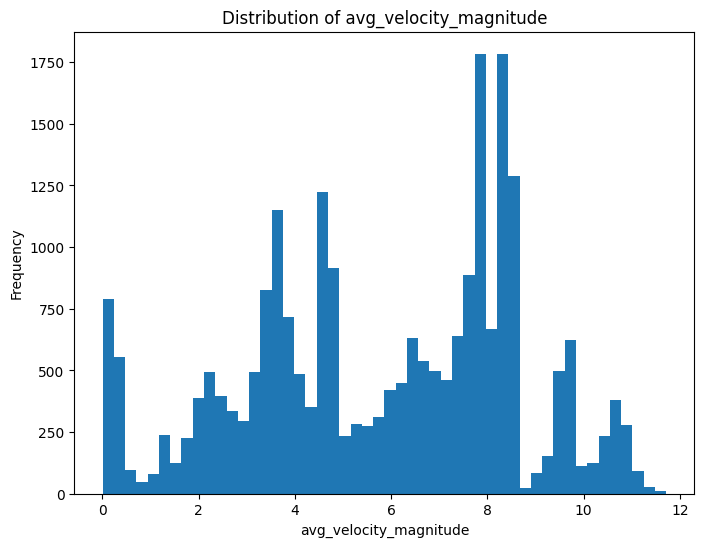

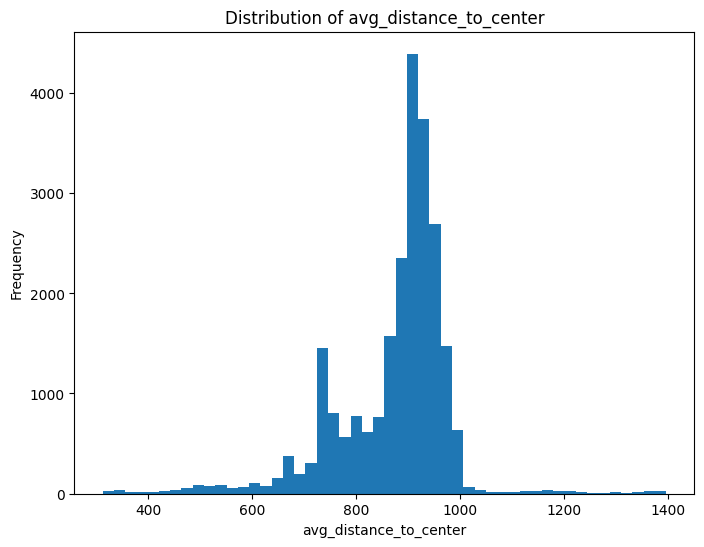

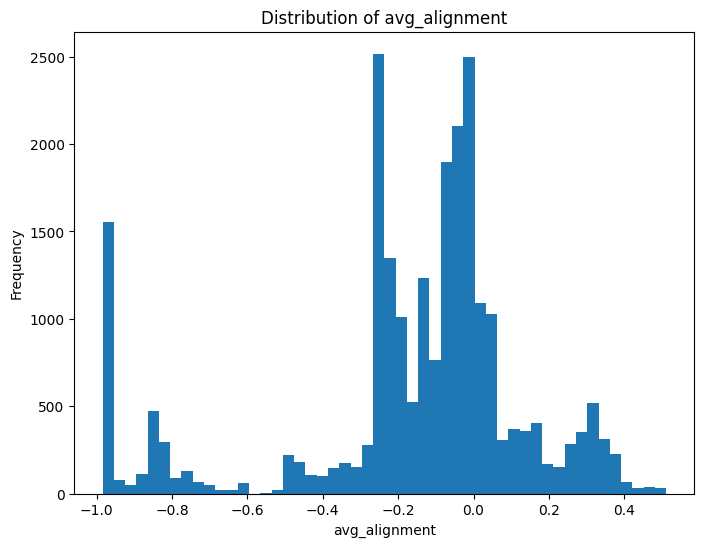

In [15]:
import matplotlib.pyplot as plt

aggregate_cols_to_visualize = ['avg_velocity_magnitude', 'avg_distance_to_center', 'avg_alignment']

for col in aggregate_cols_to_visualize:
    if col in df_flocking.columns:
        plt.figure(figsize=(8, 6))
        plt.hist(df_flocking[col], bins=50)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()
    else:
        print(f"Column '{col}' not found in df_flocking.")


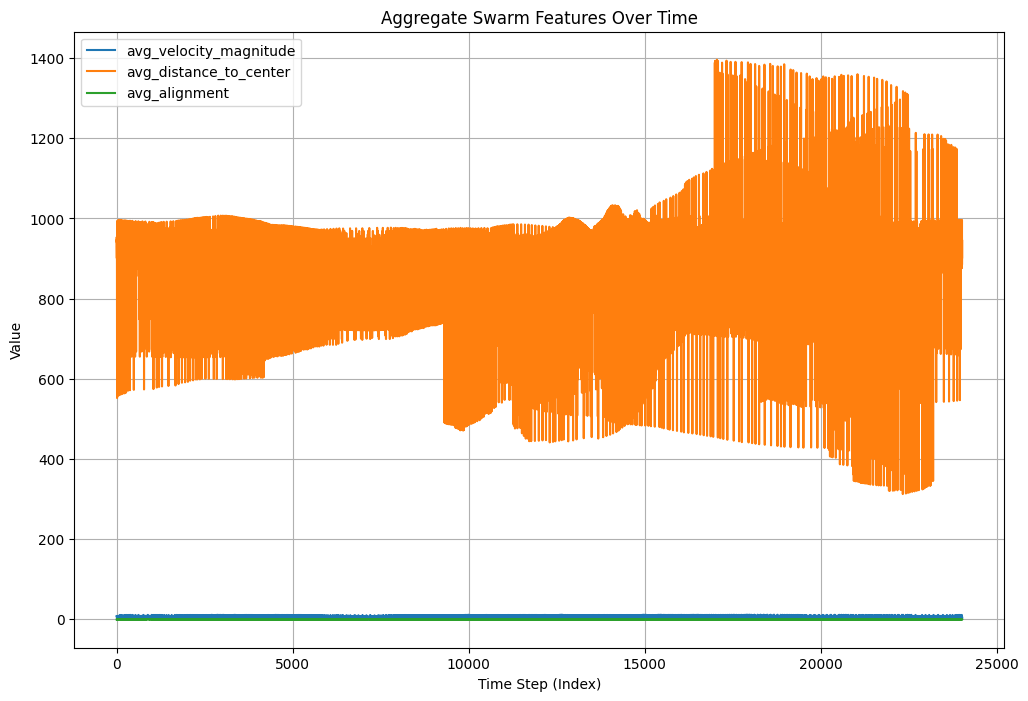

In [16]:
import matplotlib.pyplot as plt

aggregate_cols_to_plot = ['avg_velocity_magnitude', 'avg_distance_to_center', 'avg_alignment']

plt.figure(figsize=(12, 8))
for col in aggregate_cols_to_plot:
    if col in df_flocking.columns:
        plt.plot(df_flocking.index, df_flocking[col], label=col) # Assuming time is represented by the index
    else:
        print(f"Column '{col}' not found in df_flocking.")

plt.title('Aggregate Swarm Features Over Time')
plt.xlabel('Time Step (Index)') # Adjust label if you have a specific time column
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# Ensure all arrays have the same length for combination
# Access the columns directly from the DataFrame
min_len = min(len(df_flocking['avg_velocity_magnitude']), len(df_flocking['avg_distance_to_center']), len(df_flocking['avg_alignment']))

data = pd.DataFrame({
    'avg_velocity_magnitude': df_flocking['avg_velocity_magnitude'][:min_len],
    'avg_distance_to_center': df_flocking['avg_distance_to_center'][:min_len],
    'avg_alignment': df_flocking['avg_alignment'][:min_len]
})

print(f"Synthetic data shape: {data.shape}")
print(data.head())

Synthetic data shape: (24015, 3)
   avg_velocity_magnitude  avg_distance_to_center  avg_alignment
0                8.346054              942.503578      -0.264251
1                8.405831              953.482680      -0.264271
2                7.787144              912.604185      -0.264238
3                6.447582              935.923303      -0.764597
4                7.189942              929.381731      -0.304358


In [18]:
# --- 2. Preprocess Data (Important for GMMs) ---
# It's highly recommended to scale our features, especially if they are on different scales.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)



In [19]:
# --- 3. Determine Range of Components to Test ---
n_components_range = range(1, 15) # Test from 1 to 14 components

# --- 4. Fit GMMs and Calculate BIC/AIC ---
bic = []
aic = []
lowest_bic = np.inf
best_gmm = None

for n_components in n_components_range:
    # Define a GMM model
    # covariance_type='full' is the default and most flexible
    # max_iter can be increased if convergence issues arise
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)

    # Fit the model to the scaled data
    gmm.fit(X_scaled)

    # Calculate BIC and AIC
    bic.append(gmm.bic(X_scaled))
    aic.append(gmm.aic(X_scaled))

    # Keep track of the best GMM based on BIC
    if bic[-1] < lowest_bic:
        lowest_bic = bic[-1]
        best_gmm = gmm

print(f"\nOptimal number of components according to BIC: {best_gmm.n_components}")




Optimal number of components according to BIC: 14


In [20]:
cluster_labels = best_gmm.predict(X_scaled)
data['cluster_label'] = cluster_labels

In [21]:
print("\nMean feature values per cluster (original scale):")
print(data.groupby('cluster_label').mean())


Mean feature values per cluster (original scale):
               avg_velocity_magnitude  avg_distance_to_center  avg_alignment
cluster_label                                                               
0                            7.277666              900.597326      -0.824237
1                            3.933459              922.447191      -0.139634
2                            2.699689              660.199957       0.076446
3                            8.899048              926.991113      -0.026827
4                           10.581913              891.401929       0.313331
5                            8.457994              790.054844      -0.032697
6                            0.235559              731.654686       0.010271
7                            6.372496              895.625886      -0.198947
8                            2.058433              924.575542       0.086854
9                            5.498109              508.709524       0.365733
10                       

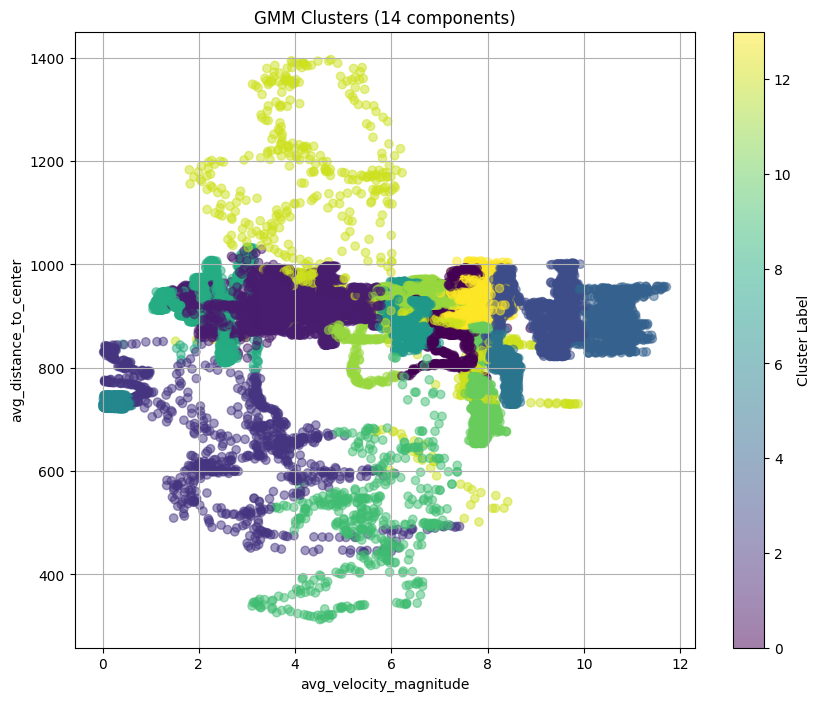

In [22]:
import matplotlib.pyplot as plt

# You can choose any two of your aggregate features to plot
feature1 = 'avg_velocity_magnitude'
feature2 = 'avg_distance_to_center'

plt.figure(figsize=(10, 8))
plt.scatter(data[feature1], data[feature2], c=data['cluster_label'], cmap='viridis', alpha=0.5)
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.title(f'GMM Clusters ({best_gmm.n_components} components)')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()

# You can create similar plots for other pairs of features


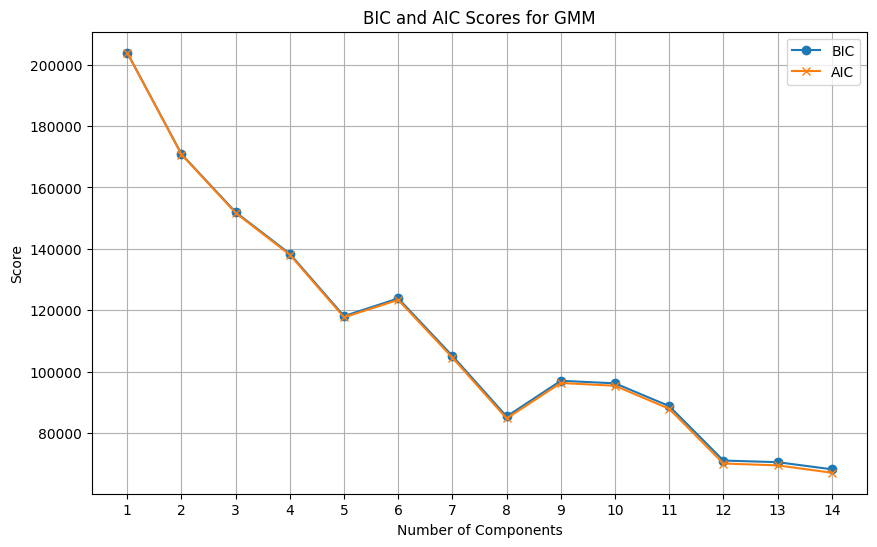


--- Analysis with Best GMM (14 components) ---
Cluster assignments for the first 10 data points:
   avg_velocity_magnitude  avg_distance_to_center  avg_alignment  \
0                8.346054              942.503578      -0.264251   
1                8.405831              953.482680      -0.264271   
2                7.787144              912.604185      -0.264238   
3                6.447582              935.923303      -0.764597   
4                7.189942              929.381731      -0.304358   
5                7.680784              900.855275      -0.264283   
6                7.243821              947.852255      -0.856056   
7                4.363400              932.151029      -0.258021   
8                8.340536              919.792465      -0.264272   
9                7.846184              750.083271      -0.974103   

   cluster_label  
0             13  
1             13  
2             13  
3              0  
4             11  
5             13  
6              0  
7

In [23]:
# --- 5. Visualize BIC and AIC ---
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, bic, marker='o', label='BIC')
plt.plot(n_components_range, aic, marker='x', label='AIC')
plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.title('BIC and AIC Scores for GMM')
plt.xticks(n_components_range)
plt.legend()
plt.grid(True)
plt.show()

# --- Optional: Further analysis with the best GMM ---
if best_gmm:
    # Corrected line: use best_gmm.n_components instead of best_gmm.n_components_
    print(f"\n--- Analysis with Best GMM ({best_gmm.n_components} components) ---")
    # Predict clusters for your data
    cluster_labels = best_gmm.predict(X_scaled)
    data['cluster_label'] = cluster_labels
    print("Cluster assignments for the first 10 data points:")
    print(data.head(10)[['avg_velocity_magnitude', 'avg_distance_to_center', 'avg_alignment', 'cluster_label']])

    # You can also inspect the means and covariances of the components
    print("\nMeans of the components (scaled features):")
    print(best_gmm.means_)
    print("\nCovariances of the components (first component's covariance matrix):")
    print(best_gmm.covariances_[0]) # Example: print covariance of the first component

    # To get means back to original scale (approximate, more complex for non-diagonal covariance)
    original_scale_means = scaler.inverse_transform(best_gmm.means_)
    print("\nMeans of the components (approx. original scale):")
    print(original_scale_means)

    # You can now analyze the characteristics of each cluster/component
    # For example, mean values of original features for each cluster
    print("\nMean feature values per cluster (original scale):")
    print(data.groupby('cluster_label').mean())

## Analyzing our GMM clusters and exploring potential "thermodynamic" interpretations.
- Analyze the mean features per cluster (which we've already done, but let's look at the output again to interpret it).
- Analyze transitions between clusters over time.
- Calculate a simple measure of "entropy" based on the spatial distribution.

Step 1: Re-examine Mean Feature Values Per Cluster

In [24]:
print("\nMean feature values per cluster (original scale):")
print(data.groupby('cluster_label').mean())


Mean feature values per cluster (original scale):
               avg_velocity_magnitude  avg_distance_to_center  avg_alignment
cluster_label                                                               
0                            7.277666              900.597326      -0.824237
1                            3.933459              922.447191      -0.139634
2                            2.699689              660.199957       0.076446
3                            8.899048              926.991113      -0.026827
4                           10.581913              891.401929       0.313331
5                            8.457994              790.054844      -0.032697
6                            0.235559              731.654686       0.010271
7                            6.372496              895.625886      -0.198947
8                            2.058433              924.575542       0.086854
9                            5.498109              508.709524       0.365733
10                       

Step 2: Analyze Transitions Between Clusters

In [25]:
print("\nSequence of cluster labels over time (first 20 time steps):")
print(data['cluster_label'].head(20))

# You can also calculate the frequency of transitions between clusters
# This involves looking at pairs of consecutive cluster labels
transitions = pd.crosstab(data['cluster_label'].shift(1), data['cluster_label'])
print("\nTransition matrix (from row cluster to column cluster):")
print(transitions)


Sequence of cluster labels over time (first 20 time steps):
0     13
1     13
2     13
3      0
4     11
5     13
6      0
7      1
8     13
9     10
10    13
11     2
12    10
13    11
14    10
15    10
16    11
17    11
18     0
19     7
Name: cluster_label, dtype: int64

Transition matrix (from row cluster to column cluster):
cluster_label   0     1    2     3    4    5    6    7    8    9    10   11  \
cluster_label                                                                 
0.0             72   408   60   138   86   56   27   66   81   11   94   62   
1.0            389  1988  235   523  388  652  137  383  478  122  504  344   
2.0             47   230   86    72   67   10   41   42   55   10   73   49   
3.0            136   547   61  1115  109   44    1  219  122   49  154  117   
4.0             81   394   67   117  102   44   23   72   89   19   82   79   
5.0             53   652   11    34   58  129    0  105   94   81  109   45   
6.0             27   136   37     3 

In [26]:
transition_probabilities = transitions.div(transitions.sum(axis=1), axis=0)
print("\nNormalized Transition Matrix (Probabilities):")
print(transition_probabilities)


Normalized Transition Matrix (Probabilities):
cluster_label        0         1         2         3         4         5   \
cluster_label                                                               
0.0            0.056872  0.322275  0.047393  0.109005  0.067930  0.044234   
1.0            0.057046  0.291538  0.034463  0.076697  0.056900  0.095615   
2.0            0.055294  0.270588  0.101176  0.084706  0.078824  0.011765   
3.0            0.047887  0.192606  0.021479  0.392606  0.038380  0.015493   
4.0            0.063035  0.306615  0.052140  0.091051  0.079377  0.034241   
5.0            0.033544  0.412658  0.006962  0.021519  0.036709  0.081646   
6.0            0.020706  0.104294  0.028374  0.002301  0.024540  0.000000   
7.0            0.058868  0.280755  0.031698  0.144906  0.044528  0.075472   
8.0            0.052557  0.331676  0.042614  0.104403  0.056818  0.067472   
9.0            0.057778  0.251111  0.026667  0.113333  0.035556  0.226667   
10.0           0.058096  0.31

Step 3: Calculate a Simple Measure of "Entropy" (Spatial Distribution) - A basic way to quantify the "disorder" in the spatial distribution is to use the concept of spatial entropy. One simple approach is to grid the space and calculate the entropy of the distribution of agents across these grid cells. However, this requires knowing the bounds of your simulation space and choosing an appropriate grid size.

A simpler, though less direct, approach related to spatial distribution that we can calculate from your existing data is the entropy of the distribution of distances to the swarm center. While not a true spatial entropy, it can give an indication of how dispersed or concentrated the agents are around the center.



In [27]:
from scipy.stats import entropy, gaussian_kde

# Calculate the distribution of distances to the center for each time step
# For simplicity, we'll use a kernel density estimate (KDE) for a smooth distribution
# Note: KDE can be computationally intensive for very large datasets

# You'll need to adapt this if you have a different number of agents
distances_data = []
for i in range(1, 201): # Assuming up to 200 agents
    x_col = f'x{i}'
    y_col = f'y{i}'
    if x_col in df_flocking.columns and y_col in df_flocking.columns:
        distance = np.sqrt((df_flocking[x_col] - df_flocking['swarm_center_x'])**2 + (df_flocking[y_col] - df_flocking['swarm_center_y'])**2)
        distances_data.append(distance)

# Stack the distances for all agents and time steps into a single array
all_distances = pd.concat(distances_data, axis=1).values.flatten()
all_distances = all_distances[~np.isnan(all_distances)] # Remove NaNs

if len(all_distances) > 0:
    # Estimate the probability density function using KDE
    kde = gaussian_kde(all_distances)
    # Evaluate the KDE at some points to get a discrete probability distribution
    # Choose a range and number of points based on your distance data
    distance_bins = np.linspace(all_distances.min(), all_distances.max(), 100) # Adjust binning as needed
    probabilities = kde.evaluate(distance_bins)
    probabilities /= probabilities.sum() # Normalize to get probabilities

    # Calculate the entropy of the distribution
    # Add a small epsilon to avoid log(0)
    epsilon = 1e-10
    spatial_entropy = entropy(probabilities + epsilon)

    print(f"\nApproximate spatial entropy (based on distance to center): {spatial_entropy}")
else:
    print("\nCould not calculate spatial entropy: No valid distance data found.")


Approximate spatial entropy (based on distance to center): 4.151901988564391


In [28]:
# Assuming you have already calculated 'spatial_entropy' for each time step
    # You might need to ensure 'spatial_entropy' is a Series aligned with your 'data' DataFrame

    # If spatial_entropy was calculated as a single value for the whole dataset,
    # you would need to calculate it *per time step* to do this analysis.

# Let's create a 'spatial_entropy' column in our data DataFrame:

def calculate_spatial_entropy_per_timestep(df):
    """
    Calculates the approximate spatial entropy of the swarm for each time step
    based on the distribution of distances to the swarm center.

    Args:
        df (pd.DataFrame): DataFrame containing agent positions (x, y) and
                           the calculated swarm center (swarm_center_x, swarm_center_y).

    Returns:
        pd.Series: A Series containing the spatial entropy for each time step,
                   aligned with the input DataFrame's index.
    """
    spatial_entropies = []
    epsilon = 1e-10 # Small value to avoid log(0)

    # Assuming position columns are named x1, y1, x2, y2, etc.
    # You'll need to adapt this if your column names are different or you have a different number of agents
    x_pos_cols = [col for col in df.columns if col.startswith('x') and col[1:].isdigit()]
    y_pos_cols = [col for col in df.columns if col.startswith('y') and col[1:].isdigit()]


    for index, row in df.iterrows():
        distances_to_center = []
        swarm_center_x = row['swarm_center_x']
        swarm_center_y = row['swarm_center_y']

        for i in range(1, 201): # Assuming up to 200 agents
            x_col = f'x{i}'
            y_col = f'y{i}'
            if x_col in row and y_col in row and pd.notna(row[x_col]) and pd.notna(row[y_col]):
                 distance = np.sqrt((row[x_col] - swarm_center_x)**2 + (row[y_col] - swarm_center_y)**2)
                 distances_to_center.append(distance)

        if len(distances_to_center) > 1: # Need at least two points for KDE
            # Estimate the probability density function using KDE
            try:
                kde = gaussian_kde(distances_to_center)
                # Evaluate the KDE at some points to get a discrete probability distribution
                # Choose a range and number of points based on your distance data
                # Use a small range if all distances are very similar to avoid issues
                min_dist = min(distances_to_center)
                max_dist = max(distances_to_center)
                if min_dist == max_dist: # Handle cases where all distances are the same
                     spatial_entropies.append(0) # Or a very small number
                else:
                    distance_bins = np.linspace(min_dist, max_dist, 50) # Adjusted bins
                    probabilities = kde.evaluate(distance_bins)
                    probabilities /= probabilities.sum() # Normalize to get probabilities

                    # Calculate the entropy of the distribution
                    spatial_entropies.append(entropy(probabilities + epsilon))
            except np.linalg.LinAlgError:
                 # Handle cases where KDE estimation fails (e.g., all points are identical)
                 spatial_entropies.append(0) # Assign low entropy for highly clustered states
            except ValueError:
                 # Handle cases with potential issues in KDE input
                 spatial_entropies.append(np.nan) # Or a specific value
        else:
            # If there's only one agent or no valid distance data, entropy is not well-defined
            spatial_entropies.append(np.nan) # Or 0, depending on interpretation

    return pd.Series(spatial_entropies, index=df.index)

# Assuming your 'data' DataFrame is aligned with 'df_flocking' by index
# and that 'swarm_center_x' and 'swarm_center_y' have been calculated and added to df_flocking
data['spatial_entropy'] = calculate_spatial_entropy_per_timestep(df_flocking)

# Remove rows where spatial_entropy could not be calculated (e.g., only one agent)
data.dropna(subset=['spatial_entropy'], inplace=True)

print("\nMean Spatial Entropy per Cluster:")
print(data.groupby('cluster_label')['spatial_entropy'].mean())



Mean Spatial Entropy per Cluster:
cluster_label
0     3.799737
1     3.782166
2     3.603687
3     3.767049
4     3.782778
5     3.798217
6     3.492488
7     3.774251
8     3.777056
9     3.389129
10    3.860865
11    3.782821
12    3.687565
13    3.792311
Name: spatial_entropy, dtype: float64


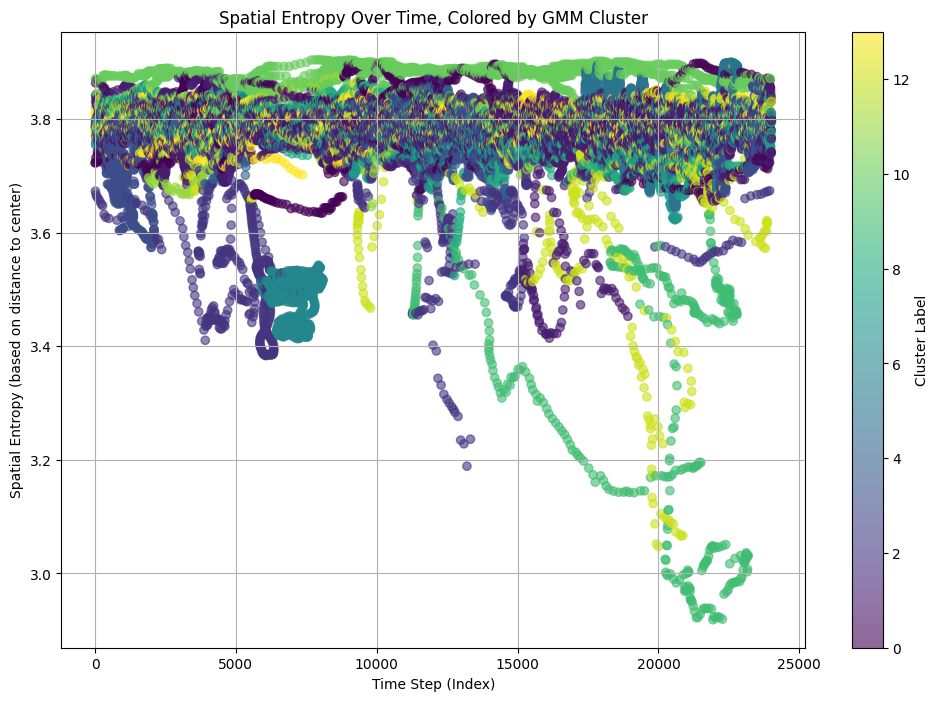

In [29]:
plt.figure(figsize=(12, 8))
# Plot spatial entropy over time, color-coded by cluster label
scatter = plt.scatter(data.index, data['spatial_entropy'], c=data['cluster_label'], cmap='viridis', alpha=0.6)
plt.xlabel('Time Step (Index)')
plt.ylabel('Spatial Entropy (based on distance to center)')
plt.title('Spatial Entropy Over Time, Colored by GMM Cluster')
plt.colorbar(scatter, label='Cluster Label')
plt.grid(True)
plt.show()


Correlation Matrix (Spatial Entropy vs. Aggregate Features):
                        spatial_entropy  avg_velocity_magnitude  \
spatial_entropy                1.000000                0.402938   
avg_velocity_magnitude         0.402938                1.000000   
avg_distance_to_center         0.408259                0.072372   
avg_alignment                 -0.378982               -0.150883   

                        avg_distance_to_center  avg_alignment  
spatial_entropy                       0.408259      -0.378982  
avg_velocity_magnitude                0.072372      -0.150883  
avg_distance_to_center                1.000000       0.010766  
avg_alignment                         0.010766       1.000000  


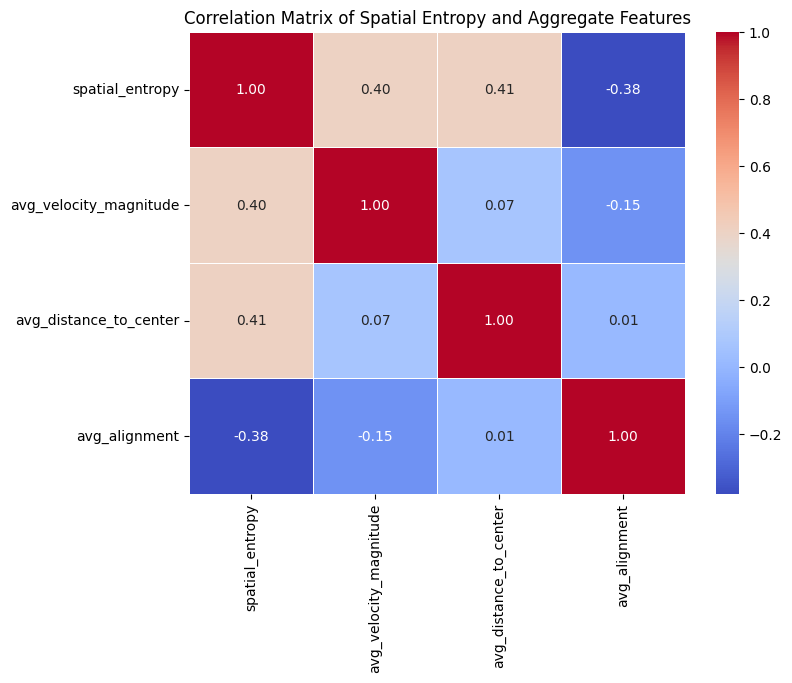

In [30]:
# Calculate the correlation matrix
correlation_matrix = data[['spatial_entropy', 'avg_velocity_magnitude', 'avg_distance_to_center', 'avg_alignment']].corr()

print("\nCorrelation Matrix (Spatial Entropy vs. Aggregate Features):")
print(correlation_matrix)

import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Spatial Entropy and Aggregate Features')
plt.show()

In [31]:
# Calculate the difference in spatial entropy between consecutive time steps
data['entropy_change'] = data['spatial_entropy'].diff()

# Identify transitions (where the cluster label changes from the previous time step)
data['cluster_transition'] = (data['cluster_label'].shift(1) != data['cluster_label'])

# Filter for rows where a transition occurred
transitions_df = data[data['cluster_transition']].copy()

# Analyze the average entropy change for transitions between specific cluster pairs
# This can be done by grouping by the previous and current cluster labels
if not transitions_df.empty:
    average_entropy_change_during_transitions = transitions_df.groupby(['cluster_label', data['cluster_label'].shift(1)])['entropy_change'].mean().unstack()
    print("\nAverage Entropy Change During Transitions (From row cluster to column cluster):")
    print(average_entropy_change_during_transitions)
else:
    print("\nNo cluster transitions found to analyze entropy changes.")


Average Entropy Change During Transitions (From row cluster to column cluster):
cluster_label      0.0       1.0       2.0       3.0       4.0       5.0   \
cluster_label                                                               
0                   NaN  0.025371  0.184535  0.036720  0.027412 -0.016240   
1             -0.010838       NaN  0.169886  0.014087  0.003454 -0.014377   
2             -0.184879 -0.168483       NaN -0.080891 -0.169590 -0.201224   
3             -0.026654 -0.019120  0.120654       NaN -0.011990 -0.099926   
4             -0.029552 -0.000066  0.161357  0.000768       NaN -0.004454   
5              0.007275  0.010833  0.195089  0.100857 -0.002743       NaN   
6             -0.251589 -0.294223  0.007083 -0.305148 -0.295001       NaN   
7             -0.029056 -0.014531  0.168881  0.008141 -0.000250 -0.065824   
8             -0.032762 -0.007465  0.178533  0.011738  0.009664 -0.050658   
9             -0.418281 -0.394949 -0.249214 -0.249896 -0.313040 -0.48115

Visualize Spatial Entropy vs. Other Aggregate Features (Scatter Plots):
Create scatter plots of spatial_entropy against avg_velocity_magnitude, avg_distance_to_center, and avg_alignment, color-coded by the GMM cluster labels. This will visually show how entropy relates to these other aggregate measures within and across different clusters.

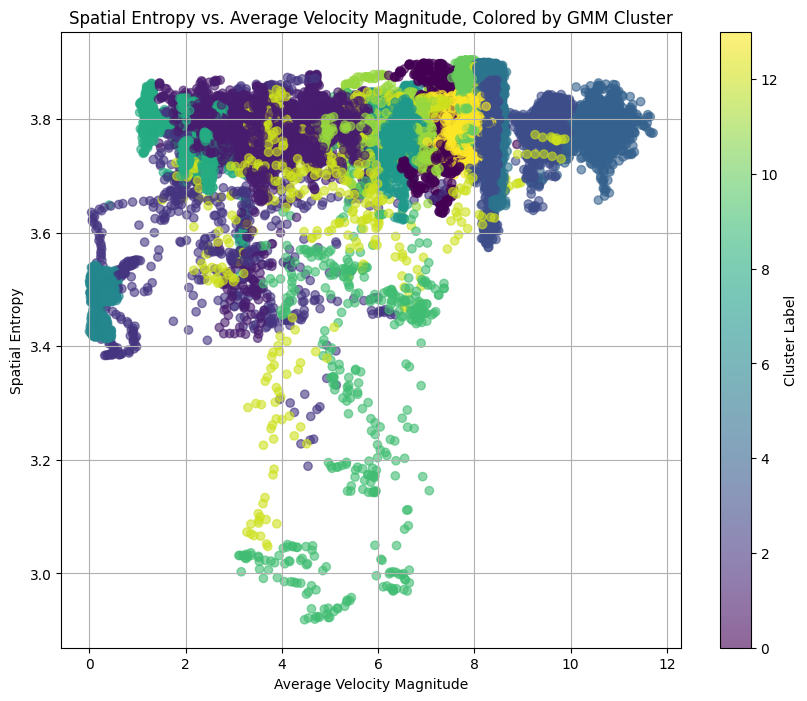

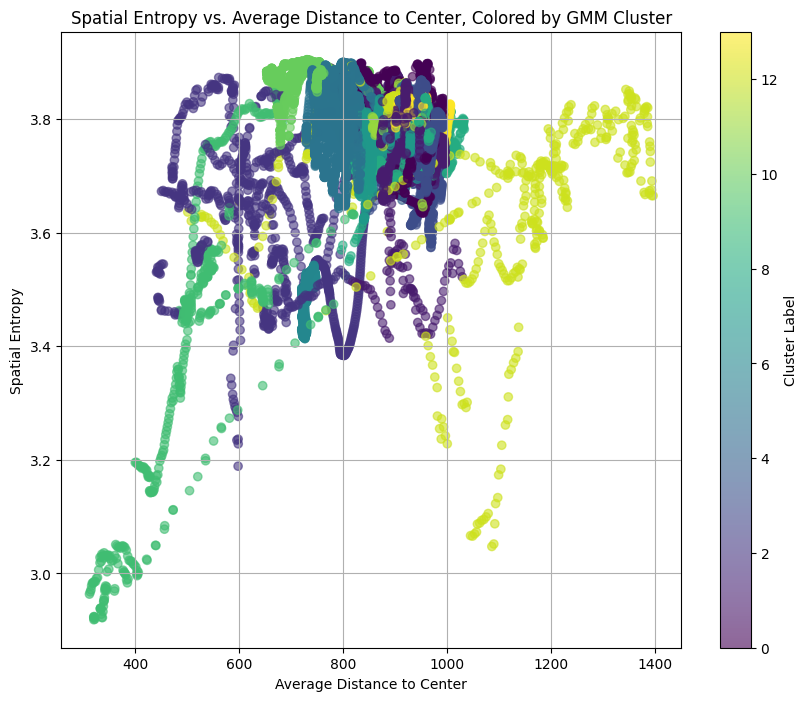

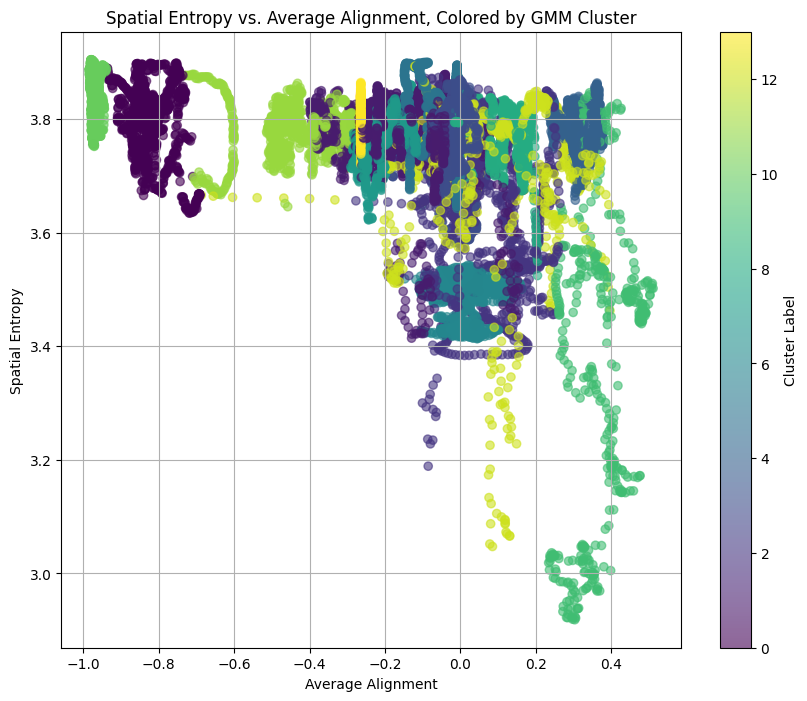

In [32]:
# Scatter plot: Entropy vs. Average Velocity Magnitude
plt.figure(figsize=(10, 8))
scatter = plt.scatter(data['avg_velocity_magnitude'], data['spatial_entropy'], c=data['cluster_label'], cmap='viridis', alpha=0.6)
plt.xlabel('Average Velocity Magnitude')
plt.ylabel('Spatial Entropy')
plt.title('Spatial Entropy vs. Average Velocity Magnitude, Colored by GMM Cluster')
plt.colorbar(scatter, label='Cluster Label')
plt.grid(True)
plt.show()

# Scatter plot: Entropy vs. Average Distance to Center
plt.figure(figsize=(10, 8))
scatter = plt.scatter(data['avg_distance_to_center'], data['spatial_entropy'], c=data['cluster_label'], cmap='viridis', alpha=0.6)
plt.xlabel('Average Distance to Center')
plt.ylabel('Spatial Entropy')
plt.title('Spatial Entropy vs. Average Distance to Center, Colored by GMM Cluster')
plt.colorbar(scatter, label='Cluster Label')
plt.grid(True)
plt.show()

# Scatter plot: Entropy vs. Average Alignment
plt.figure(figsize=(10, 8))
scatter = plt.scatter(data['avg_alignment'], data['spatial_entropy'], c=data['cluster_label'], cmap='viridis', alpha=0.6)
plt.xlabel('Average Alignment')
plt.ylabel('Spatial Entropy')
plt.title('Spatial Entropy vs. Average Alignment, Colored by GMM Cluster')
plt.colorbar(scatter, label='Cluster Label')
plt.grid(True)
plt.show()

Further Analyze Transition Pathways and Entropy Changes:
Beyond the average entropy change matrix, you could focus on specific transitions of interest. For example, examine transitions between clusters that represent "ordered" and "disordered" states.
You could also visualize the time series of entropy and highlight periods where transitions occur.

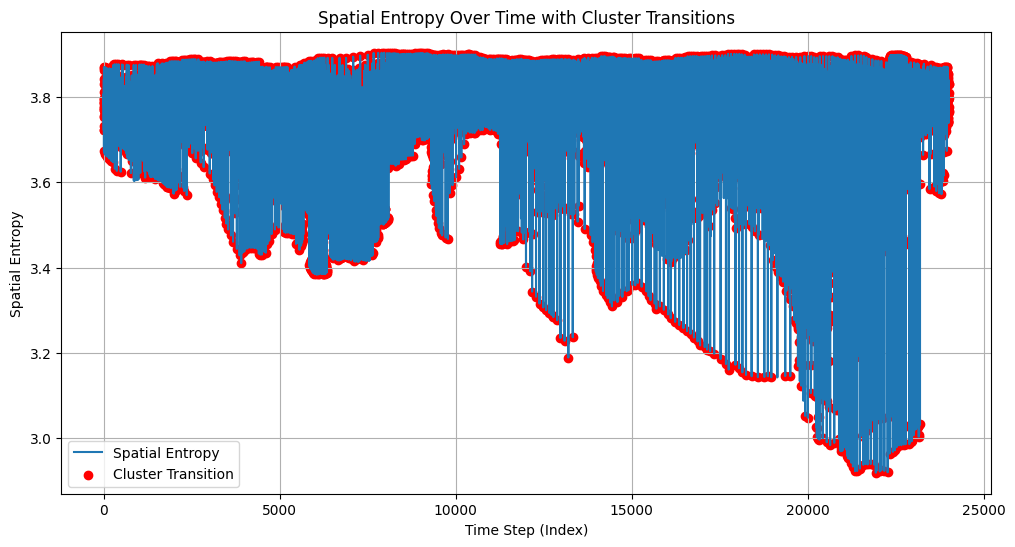

In [33]:
# Visualize Entropy Over Time with Transition Points (Optional)
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['spatial_entropy'], label='Spatial Entropy')
# Highlight transition points (where cluster_transition is True)
transition_indices = data[data['cluster_transition']].index
plt.scatter(transition_indices, data.loc[transition_indices, 'spatial_entropy'], color='red', marker='o', label='Cluster Transition')
plt.xlabel('Time Step (Index)')
plt.ylabel('Spatial Entropy')
plt.title('Spatial Entropy Over Time with Cluster Transitions')
plt.legend()
plt.grid(True)
plt.show()

## Introducing Next steps - Agent Base Modeling Forces

Analyzing Cluster Behavior with Respect to Alignment, Cohesion, and Separation:

We'll revisit the output of the mean feature values per cluster and explicitly interpret each cluster in terms of these three behaviors:

In [34]:
print("\nMean feature values per cluster (original scale):")
print(data.groupby('cluster_label').mean())


Mean feature values per cluster (original scale):
               avg_velocity_magnitude  avg_distance_to_center  avg_alignment  \
cluster_label                                                                  
0                            7.277666              900.597326      -0.824237   
1                            3.933459              922.447191      -0.139634   
2                            2.699689              660.199957       0.076446   
3                            8.899048              926.991113      -0.026827   
4                           10.581913              891.401929       0.313331   
5                            8.457994              790.054844      -0.032697   
6                            0.235559              731.654686       0.010271   
7                            6.372496              895.625886      -0.198947   
8                            2.058433              924.575542       0.086854   
9                            5.498109              508.709524       0

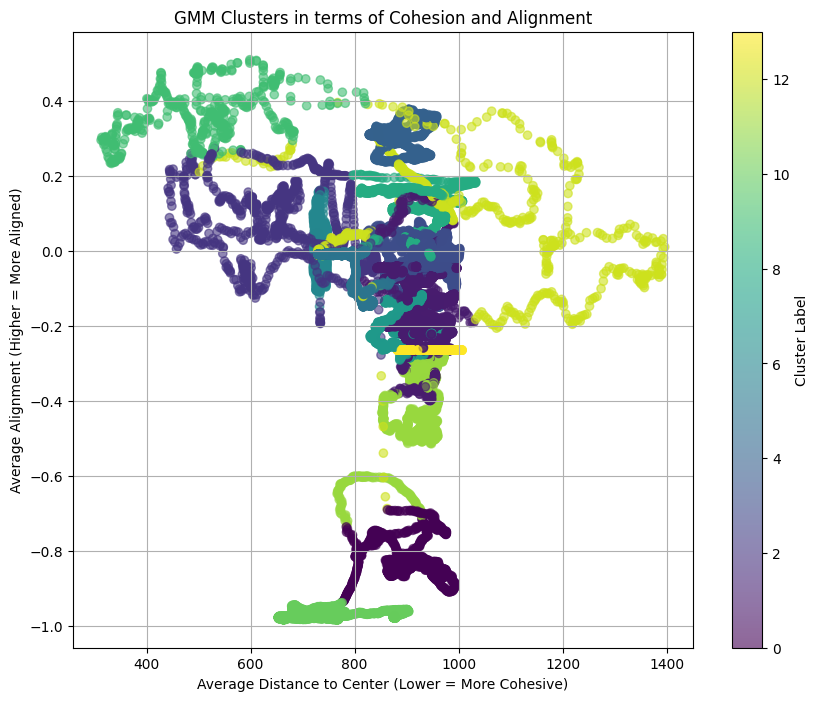

In [35]:
# Scatter plot: Average Distance to Center vs. Average Alignment
plt.figure(figsize=(10, 8))
scatter = plt.scatter(data['avg_distance_to_center'], data['avg_alignment'], c=data['cluster_label'], cmap='viridis', alpha=0.6)
plt.xlabel('Average Distance to Center (Lower = More Cohesive)')
plt.ylabel('Average Alignment (Higher = More Aligned)')
plt.title('GMM Clusters in terms of Cohesion and Alignment')
plt.colorbar(scatter, label='Cluster Label')
plt.grid(True)
plt.show()

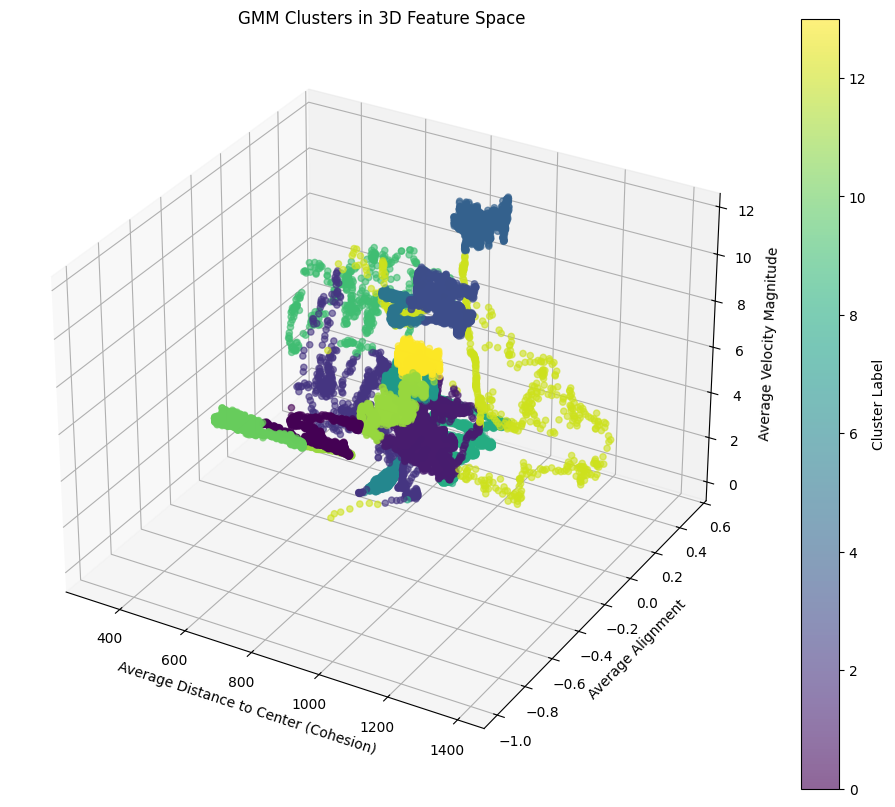

In [36]:
# You can also create a 3D scatter plot if you want to include average velocity magnitude
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(data['avg_distance_to_center'], data['avg_alignment'], data['avg_velocity_magnitude'], c=data['cluster_label'], cmap='viridis', alpha=0.6)

ax.set_xlabel('Average Distance to Center (Cohesion)')
ax.set_ylabel('Average Alignment')
ax.set_zlabel('Average Velocity Magnitude')
ax.set_title('GMM Clusters in 3D Feature Space')

fig.colorbar(scatter, label='Cluster Label')
plt.show()

let's create a summary table and map your GMM clusters to descriptive behavioral labels based on their mean aggregate features (average velocity magnitude, average distance to center, and average alignment).

In [38]:
# Get the mean feature values per cluster
cluster_summary = data.groupby('cluster_label')[['avg_velocity_magnitude', 'avg_distance_to_center', 'avg_alignment']].mean()

# Add a column for behavioral interpretation (we'll fill this in manually)
cluster_summary['Behavioral_Interpretation'] = ""

# Now, manually assign behavioral interpretations based on the mean values.
# Refer to the output of cluster_summary and your understanding of flocking.

# Example (you will need to adapt this based on your actual cluster means):
# For cluster 0:
# if cluster_summary.loc[0, 'avg_velocity_magnitude'] > some_threshold and \
#    cluster_summary.loc[0, 'avg_distance_to_center'] > some_threshold and \
#    cluster_summary.loc[0, 'avg_alignment'] < some_threshold:
#     cluster_summary.loc[0, 'Behavioral_Interpretation'] = 'Dispersed/High Velocity'

# For cluster 9:
# if cluster_summary.loc[9, 'avg_velocity_magnitude'] > some_moderate_threshold and \
#    cluster_summary.loc[9, 'avg_distance_to_center'] < some_low_threshold and \
#    cluster_summary.loc[9, 'avg_alignment'] > some_high_threshold:
#     cluster_summary.loc[9, 'Behavioral_Interpretation'] = 'Flocking/Cohesive and Aligned'

# For cluster 6:
# if cluster_summary.loc[6, 'avg_velocity_magnitude'] < some_low_threshold and \
#    cluster_summary.loc[6, 'avg_distance_to_center'] > some_moderate_threshold and \
#    cluster_summary.loc[6, 'avg_alignment'] < some_low_threshold:
#     cluster_summary.loc[6, 'Behavioral_Interpretation'] = 'Resting/Stagnant'


# You will need to add similar conditional logic or manually assign
# interpretations for all your clusters (0 to 13).

print("\nCluster Behavioral Summary:")
print(cluster_summary)
cluster_summary.to_csv("gmm_cluster_behavioral_summary.csv")


Cluster Behavioral Summary:
               avg_velocity_magnitude  avg_distance_to_center  avg_alignment  \
cluster_label                                                                  
0                            7.277666              900.597326      -0.824237   
1                            3.933459              922.447191      -0.139634   
2                            2.699689              660.199957       0.076446   
3                            8.899048              926.991113      -0.026827   
4                           10.581913              891.401929       0.313331   
5                            8.457994              790.054844      -0.032697   
6                            0.235559              731.654686       0.010271   
7                            6.372496              895.625886      -0.198947   
8                            2.058433              924.575542       0.086854   
9                            5.498109              508.709524       0.365733   
10         

In [39]:
# Add a column for behavioral interpretation
cluster_summary['Behavioral_Interpretation'] = ""

# Manually assign behavioral interpretations based on the agreed-upon labels for each cluster.
cluster_summary.loc[0, 'Behavioral_Interpretation'] = 'High Velocity Dispersed (Anti-aligned)'
cluster_summary.loc[1, 'Behavioral_Interpretation'] = 'Low Velocity Dispersed (Slightly Anti-aligned)'
cluster_summary.loc[2, 'Behavioral_Interpretation'] = 'Moderately Cohesive & Slow (Slightly Aligned)'
cluster_summary.loc[3, 'Behavioral_Interpretation'] = 'Very High Velocity Dispersed (Near Neutral Alignment)'
cluster_summary.loc[4, 'Behavioral_Interpretation'] = 'Extremely High Velocity Dispersed (Moderately Aligned)'
cluster_summary.loc[5, 'Behavioral_Interpretation'] = 'High Velocity Somewhat Cohesive (Near Neutral Alignment)'
cluster_summary.loc[6, 'Behavioral_Interpretation'] = 'Resting / Stagnant (Moderately Cohesive & Neutral Alignment)'
cluster_summary.loc[7, 'Behavioral_Interpretation'] = 'Moderate Velocity Dispersed (Slightly Anti-aligned)'
cluster_summary.loc[8, 'Behavioral_Interpretation'] = 'Very Low Velocity Dispersed (Slightly Aligned)'
cluster_summary.loc[9, 'Behavioral_Interpretation'] = 'Flocking / Cohesive & Aligned (Optimal Flocking)'
cluster_summary.loc[10, 'Behavioral_Interpretation'] = 'High Velocity Dispersed (Strongly Anti-aligned / Splitting)'
cluster_summary.loc[11, 'Behavioral_Interpretation'] = 'Moderate Velocity Dispersed (Anti-aligned)'
cluster_summary.loc[12, 'Behavioral_Interpretation'] = 'Highly Dispersed & Moderate Velocity (Near Neutral Alignment)'
cluster_summary.loc[13, 'Behavioral_Interpretation'] = 'High Velocity Dispersed (Slightly Anti-alignment)'

print("\nCluster Behavioral Summary with Interpretations:")
print(cluster_summary)

# You might want to save this summary to a CSV file for later use:
# cluster_summary.to_csv("gmm_cluster_behavioral_summary_with_interpretations.csv")


Cluster Behavioral Summary with Interpretations:
               avg_velocity_magnitude  avg_distance_to_center  avg_alignment  \
cluster_label                                                                  
0                            7.277666              900.597326      -0.824237   
1                            3.933459              922.447191      -0.139634   
2                            2.699689              660.199957       0.076446   
3                            8.899048              926.991113      -0.026827   
4                           10.581913              891.401929       0.313331   
5                            8.457994              790.054844      -0.032697   
6                            0.235559              731.654686       0.010271   
7                            6.372496              895.625886      -0.198947   
8                            2.058433              924.575542       0.086854   
9                            5.498109              508.709524       0.

In [43]:
print("\nMean feature values per cluster (original scale):")
print(data.groupby('cluster_label').mean())


Mean feature values per cluster (original scale):
               avg_velocity_magnitude  avg_distance_to_center  avg_alignment  \
cluster_label                                                                  
0                            7.277666              900.597326      -0.824237   
1                            3.933459              922.447191      -0.139634   
2                            2.699689              660.199957       0.076446   
3                            8.899048              926.991113      -0.026827   
4                           10.581913              891.401929       0.313331   
5                            8.457994              790.054844      -0.032697   
6                            0.235559              731.654686       0.010271   
7                            6.372496              895.625886      -0.198947   
8                            2.058433              924.575542       0.086854   
9                            5.498109              508.709524       0